# **KoBERT - 다중분류모델**


**준비**

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master #KoBERT 파일 로드 

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

device = torch.device("cuda:0") #GPU
bertmodel, vocab = get_pytorch_kobert_model() #BERT model과 vocabulary 불러옴 

     |████████████████████████████████| 46.9 MB 45 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 41.5 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595739 sha256=3c3922fe8605b1fb03545a127846e877e3a6ed3f1419067ca2c4efd86175ac7d
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 29.6 MB/s 
     |████████████████████████████████| 769 kB 31.4 MB/s 
     |████████████████████████████████| 895 kB 6.7 MB/s 
     |████████████████████████████████| 3.0 MB 54.4 MB/s 
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-4ujq4w5z
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/p

-----
**전처리**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
chatbot_data = pd.read_excel('/content/drive/MyDrive/한국어_단발성_대화_데이터셋.xlsx')

chatbot_data.sample(n=10)

,Sentence,Emotion,Unnamed: 2,Unnamed: 3,Unnamed: 4,공포,5468
28420,진짜 남일이라 신경끌법도 한데대단하다 멋있다,행복,NaN,NaN,NaN,NaN,NaN
37578,단통법은 위헌이다 헌법 소원 내자,혐오,NaN,NaN,NaN,NaN,NaN
26357,나에겐 뜬 구름 잡는 소리이다,중립,NaN,NaN,NaN,NaN,NaN
10171,이게 도대체 어떻게 된건가여??!!!,놀람,NaN,NaN,NaN,NaN,NaN
20105,하체비만맞아요...ㅜㅜ,슬픔,NaN,NaN,NaN,NaN,NaN
826,막상 말 하려니까 어이구!,공포,NaN,NaN,NaN,NaN,NaN
9341,와 멜론차트 9위네요 대단하다,놀람,NaN,NaN,NaN,NaN,NaN
24108,박지원을 대통령으로,중립,NaN,NaN,NaN,NaN,NaN
5445,아이가 혼란스러울까봐 친엄마는 이제 보러오지 않겠다고 하는데요,공포,NaN,NaN,NaN,NaN,NaN
29825,시그널도. 시그널이었지만 싸인이 저에겐. 너무 센세이션이었어요,행복,NaN,NaN,NaN,NaN,NaN


In [6]:
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[24000])
print(data_list[30000])
print(data_list[-1])

['언니 동생으로 부르는게 맞는 일인가요..??', '0']
['기술적으로도 아직도 해체해서 다시 완벽히 돌려놓는게 어려운데 해체를한다고?', '1']
['당연히 그렇게 해야지 우리나라도 판매를 중단하라', '2']
['그거들은 뒤부터 미치겠어요...', '3']
['최악의 상황중 그나마 나은 방법이네. 기분은 잡치겠지만', '4']
['  요리하는것이 숙제하는것처럼 힘든저에게 용기나게 해주시고 할수 있을것같은 희망을 주셔서감사합니다!!', '5']
['와이프도 그렇고 댓글 다 볼텐데 이휘재 좀 하차 하라고 전해주세요', '6']


In [14]:
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

print(len(dataset_train))
print(len(dataset_test))

28945
9649


In [15]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [16]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [18]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

data_train[0]

using cached model


(array([   2, 1189,  517, 6188, 7245, 7063,  517,  463, 3486, 7836, 5966,
        1698,  517, 6188, 7245, 7063,  517,  463, 1281, 7870, 1801, 6885,
        7088, 5966, 1698, 5837, 5837,  517, 6188, 7245, 6398, 6037, 7063,
         517,  463,  517,  463,  517,  364,  517,  364,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(42, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 5)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

-----
**학습 모델**

In [19]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
        

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

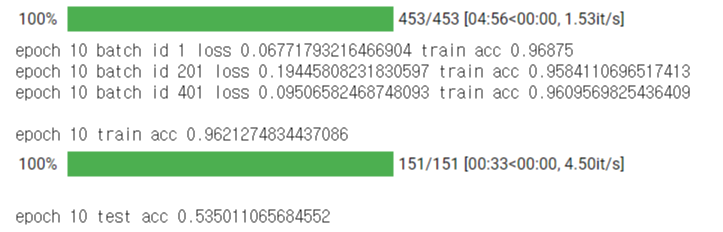

-----
**새로운 문장 테스트**

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model1.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model1(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

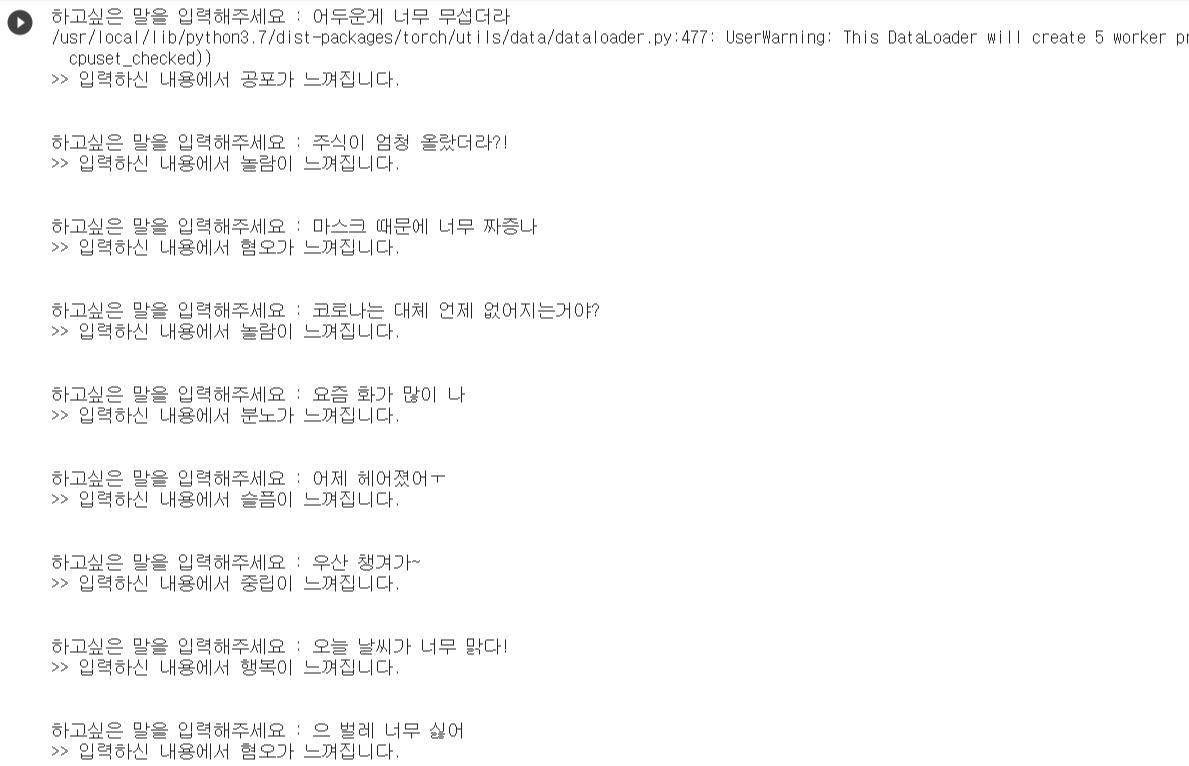

[파이썬]KoBERT로 다중 분류 모델 만들기 - 코드 : https://velog.io/@seolini43/KOBERT%EB%A1%9C-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0-%ED%8C%8C%EC%9D%B4%EC%8D%ACColab

KoBERT 개발자의 개발 리뷰기 : http://freesearch.pe.kr/archives/4981

KoBERT의 네이버 영화평 이중분류 예시 코드 : https://colab.research.google.com/github/SKTBrain/KoBERT/blob/master/scripts/NSMC/naver_review_classifications_pytorch_kobert.ipynb#scrollTo=itIExnuLbSap

